# Virtual Sites Showcase

The OpenFF Toolkit supports specifying virtual sites in a SMIRNOFF force field. This approach treats virtual sites as a feature of the potential energy function, rather than of the chemical system, cleanly seperating the system being modelled from the model itself. This notebook demonstrates the specification and use of virtual sites and compares a SMIRNOFF implementation of TIP5P water to the implementation distributed with OpenMM.

## Setup

In [1]:
import time

import numpy
import openmm
import openmm.app
import openmm.unit
from openff.interchange import Interchange
from openff.units import Quantity, unit

from openff.toolkit import ForceField, Molecule, Topology

In [2]:
def prepare_simulation(interchange: Interchange) -> openmm.app.Simulation:
    """Propagate an OpenMM System with Langevin dynamics."""
    time_step = 2 * openmm.unit.femtoseconds
    temperature = 300 * openmm.unit.kelvin
    friction = 1 / openmm.unit.picosecond
    integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

    trj_freq, data_freq = 100, 100

    simulation = interchange.to_openmm_simulation(integrator=integrator)

    # It's important to run energy minimization before computing velocities; otherwise the initial
    # velocities of virtual sites may be too high as a result of high initial forces, causing a crash
    # See https://github.com/openmm/openmm/issues/3736#issuecomment-1217250635
    simulation.minimizeEnergy()

    # Since we placed all virtual sites at [0.0, 0.0, 0.0], compute virtual site positions to avoid a crash
    simulation.context.computeVirtualSites()

    simulation.context.setVelocitiesToTemperature(temperature)

    pdb_reporter = openmm.app.PDBReporter("trajectory.pdb", trj_freq)
    state_data_reporter = openmm.app.StateDataReporter(
        "data.csv",
        data_freq,
        step=True,
        potentialEnergy=True,
        temperature=True,
        density=True,
    )
    simulation.reporters.append(pdb_reporter)
    simulation.reporters.append(state_data_reporter)

    return simulation


def run_simulation(simulation: openmm.app.Simulation, num_steps: int = 1000):
    print("Starting simulation")
    start = time.process_time()

    simulation.step(num_steps)

    end = time.process_time()
    print("Elapsed time %.2f seconds" % (end - start))
    print("Done!")

## Part 1: Run a short simulation with a virtual sites on sulfur lone pair and chloride groups

This part demonstrates the specification of virtual sites in the SMIRNOFF format.

First, we write the definition of a SMIRNOFF force field with virtual sites in OFFXML format. We will append this force field to the OpenFF Sage small molecule force field, so it only needs to specify the virtual sites we want to supplement Sage with. For details, see the [SMIRNOFF specification].

[SMIRNOFF specification]: https://openforcefield.github.io/standards/standards/smirnoff/#virtualsites-virtual-sites-for-off-atom-charges

In [3]:
vsite_offxml = """<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[*:2]-[#16X2:1]-[*:3]"
            distance="0.70 * angstrom"
            charge_increment1="0.1205*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            charge_increment3="0.1205*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.71384225*degree"
            match="all_permutations" >
        </VirtualSite>
        <VirtualSite
            type="BondCharge"
            name="EP"
            smirks="[*:2][Cl:1]"
            distance="0.4*angstrom"
            charge_increment1="0.2*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.05*kilocalories_per_mole"
            match="all_permutations" >
        </VirtualSite>
        <VirtualSite
            type="BondCharge"
            name="EP"
            smirks="[*:2][F:1]"
            distance="0.4*angstrom"
            charge_increment1="0.2*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.05*kilocalories_per_mole"
            match="all_permutations" >
        </VirtualSite>
    </VirtualSites>
</SMIRNOFF>
"""

# Load Sage and append our virtual sites
force_field = ForceField("openff-2.2.0.offxml", vsite_offxml)

Load a molecule including a divalent sulfur atom:

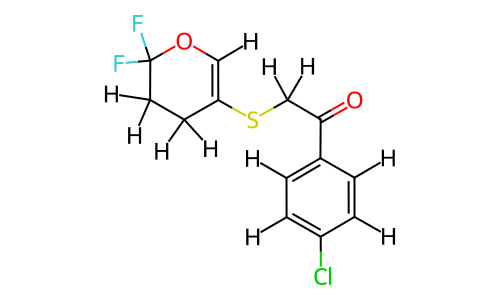

In [4]:
molecule = Molecule.from_smiles("c1cc(Cl)ccc1C(=O)CS[C]1=CO[C](F)(F)CC1")
molecule.generate_conformers(n_conformers=1)
molecule.visualize()

Create an Interchange object, which parametrizes the molecule and stores information needed for OpenMM (and other engines) to understand virtual sites as applied by a force field:

In [5]:
interchange = force_field.create_interchange(topology=molecule.to_topology())

assert "VirtualSites" in interchange.collections.keys()

n_virtual_sites = len(interchange.collections["VirtualSites"].key_map)

print(f"There are {n_virtual_sites} virtual particles in this topology.")

There are 5 virtual particles in this topology.


*This may take a moment, as it must compute partial charges for the molecule*

At this point, each of our OpenFF objects have processed and stored all of the information needed to run a simulation in OpenMM. Different [OpenMM objects](https://docs.openforcefield.org/projects/interchange/en/stable/using/output.html#openmm) can be created from an `Interchange` object:

* `openmm.System`: `Interchange.to_openmm()`
* `openmm.app.Topology`: `Interchange.to_openmm_topology()`
* `openmm.app.Simulation`: `Interchange.to_openmm_simulation()`

For simplicity, we'll just create a `Simulation` object with the function we defined above since that's all we need to run a simulation in OpenMM:

In [6]:
simulation = prepare_simulation(interchange)

run_simulation(simulation, 10000)

Starting simulation


Elapsed time 2.14 seconds
Done!


We can visualize the resulting trajectory:

In [7]:
import mdtraj

# Visualize the trajectory. There will probably be errant bonds drawn between atoms and virtual sites.
import nglview

nglview.show_mdtraj(mdtraj.load("trajectory.pdb"))

NGLWidget(max_frame=99)

## Part 2: Numerical comparison of OpenMM's TIP5P and an equivalent SMIRNOFF implementation

We will now parametrize a water box with OpenFF/SMIRNOFF and OpenMM implementations of TIP5P water.

This code examines the geometry and energy between the two, and examines cases where minimization is performed.

The virtual site definitions give rise to small differences in geometry due to how they are defined relative to their parent atoms. OpenMM's force field uses the `openmm.OutOfPlaneSite` class whereas OpenFF's force field uses `openmm.LocalCoordinatesSite`. In each case, these objects are OpenMM objects for use in OpenMM simulations; implementations in other engines are not covered here.

Virtual sites are defined geometrically in terms of a single *parent* atom and multiple *orientation* atoms. In water models, the parent atom is oxygen and the orientation atoms are the oxygen and hydrogens; in other chemistries virtual sites may be definited differently. `OutOfPlaneSite` virtual sites' positions are determined based on the positions of the orientation atoms. `LocalCoordinatesSite` virtual sites' positions relative to orientation atoms are fixed in order to adhere to the SMIRNOFF specification.

A consequence of this difference is that tiny fluctuations in the molecular geometry cause slightly different coordinates and, therefore, energy evaluations. This can arise from marginally different initial positions or from the dynamics of a simulation, but when averaged over a large number of configurations at equilibrium the descriptions should match. Further nuance is described in the [OpenMM User Guide] and API docs.

This example uses water molecules, but both OpenFF and OpenMM infrastructure support a variety of other virtual site definitions for use in other chemistries. One key difference between OpenFF and OpenMM code paths is the bookkeepping of virtual sites relative to atomistic particles. OpenMM interleaves the virtual site particles at the end of _each molecule_, whereas OpenFF places all virtual sites at the end of the `openmm.System`, topology, and related objects.

[OpenMM User Guide]: http://docs.openmm.org/8.0.0/userguide/theory/05_other_features.html#virtual-sites

First, define some supporting functions:

In [8]:
def _evaluate_positions_and_energy(
    openmm_topology: openmm.app.Topology,
    openmm_system: openmm.app.Simulation,
    particle_positions: openmm.unit.Quantity,
    minimize=False,
) -> tuple[numpy.ndarray, Quantity]:
    """
    Calculate particle positions and potential energy of the a system.

    Parameters
    ----------
    openmm_topology: openmm.app.Topology, OpenMM Topology
    openmm_system: openmm.app.System, OpenMM System
    particle_positions: openff.units.Quantity, (N, 3) array of positions in nanometers
    minimize: bool, Whether or not to perform an energy minimization before calculating energy

    Returns
    -------
    positions: numpy.ndarray, array of particle positions (as nanometers)
    energy: openmm.unit.Quantity, The potential energy of the systems

    """

    integrator = openmm.LangevinIntegrator(
        300 * openmm.unit.kelvin,
        1 / openmm.unit.picosecond,
        0.002 * openmm.unit.picoseconds,
    )

    sim = openmm.app.Simulation(openmm_topology, openmm_system, integrator)

    sim.context.setPositions(particle_positions)
    sim.context.applyConstraints(1e-5)

    if minimize:
        sim.minimizeEnergy()

    state = sim.context.getState(getEnergy=True, getPositions=True)
    ene = state.getPotentialEnergy()
    pos = openmm.unit.Quantity(
        [list(xyz) for xyz in state.getPositions().value_in_unit(openmm.unit.nanometer)],
        openmm.unit.nanometer,
    )

    return pos, ene

In [9]:
def build_water_lattice(
    num_duplicates: list[int] = [1, 1, 1],
    spacing: list[float] = [2.0, 2.0, 2.0],
) -> list[Molecule]:
    """
    Generate a box of water molecules as OpenFF Molecules

    Parameters
    ----------
        num_duplicates: list[int], The number of molecules in each dimension
        spacing: list[float], The spacing between the molecules in each dimension, implicitly in Angstrom

    Returns
    -------
        water_box: list[Molecule], A list of Molecule objcets with a 3D conformation
    """
    from math import cos, sin

    Lx, Ly, Lz = (num_duplicates[i] * spacing[i] for i in range(3))
    Z, Y, X = numpy.mgrid[
        0 : Lz : spacing[0],
        0 : Ly : spacing[1],
        0 : Lx : spacing[2],
    ]
    XYZ = [list(xyz) for xyz in zip(X.flat, Y.flat, Z.flat)]

    water_box = list([None] * len(XYZ))
    water_reference = Molecule.from_mapped_smiles("[O:1]([H:2])[H:3]")
    water_reference.atoms[0].name = "O"
    water_reference.atoms[1].name = "H1"
    water_reference.atoms[2].name = "H2"

    # Add ideal TIP5P geometry
    bond_length = Quantity(0.9572, unit.angstrom)
    theta = Quantity(104.52, unit.degree).to(unit.radian)

    water_reference.add_conformer(
        bond_length
        * Quantity(
            [
                [0.0, 0.0, 0.0],
                [-sin(theta / 2), cos(theta / 2), 0.0],
                [sin(theta / 2), cos(theta / 2), 0.0],
            ]
        )
    )

    for i, xyz in enumerate(XYZ):
        water_box[i] = Molecule(water_reference)
        water_box[i].conformers[0] = water_box[i].conformers[0] + xyz * unit.angstrom

    return water_box


def reorder(
    number_molecules: int,
    atoms_per_molecule: int = 3,
    virtual_sites_per_molecule: int = 2,
) -> list[int]:
    """Return an mapping between collated and un-collated particle indices."""
    particles_per_molecule = atoms_per_molecule + virtual_sites_per_molecule

    atoms = list()
    virtual_sites = list()

    for particle_index in range(number_molecules * particles_per_molecule):
        if particle_index % particles_per_molecule < atoms_per_molecule:
            atoms.append(particle_index)
        else:
            virtual_sites.append(particle_index)

    return atoms + virtual_sites

In [10]:
def evaluate_openmm(
    water: list[Molecule],
    openmm_force_field: openmm.app.ForceField,
    minimize: bool = False,
):
    """
    Given a list of molecules and a force field definition, calculate the
    positions and energy.

    Parameters
    ----------
        water: list[Molecule], each with a 3D conformation
        openmm_force_field: openmm.app.ForceField, OpenMM ForceField object
        minimize: bool, default = False, whether the structure should be minimized

    Returns
    -------
        xyz: List The coordinates of all particles in the system (OpenMM ordering)
        ene: float, The potential energy
    """

    # First, get an OpenMM Topology and atom positions with no virtual sites
    _topology: openmm.app.Topology = Topology.from_molecules(water).to_openmm()

    atom_positions_unitless = numpy.vstack([mol.conformers[0].m_as(unit.nanometer) for mol in water])
    atom_positions = openmm.unit.Quantity(atom_positions_unitless, openmm.unit.nanometer)

    # Use OpenMM's Modeller to add virtual particles as perscribed by the force field
    modeller = openmm.app.Modeller(_topology, atom_positions)
    modeller.addExtraParticles(openmm_force_field)

    # This topology includes virtual particles, so we can use it to create a System
    topology = modeller.getTopology()

    system: openmm.System = openmm_force_field.createSystem(topology, nonbondedMethod=openmm.app.NoCutoff)

    # Add positions of virtual particles now that the topology includes them
    particle_positions = modeller.getPositions()

    return _evaluate_positions_and_energy(topology, system, particle_positions, minimize=minimize)

In [11]:
def evaluate_openff(
    water: list[Molecule],
    force_field: ForceField,
    minimize: bool = False,
):
    """
    Given a list of molecules and a force field definition, calculate the
    positions and energy.

    Parameters
    ----------
        water: list[Molecule], each with a 3D conformation
        force_field: ForceField, an OpenFF ForceField object
        minimize: boolean, default= False, whether the structure should be minimized

    Returns
    -------
        xyz: list The coordinates of all particles in the system (OpenMM ordering)
        ene: float, The potential energy
    """
    from openff.interchange.interop.openmm import to_openmm_positions

    openff_topology = Topology.from_molecules(water)
    interchange = Interchange.from_smirnoff(force_field, openff_topology)

    return _evaluate_positions_and_energy(
        interchange.to_openmm_topology(),
        interchange.to_openmm(combine_nonbonded_forces=True),
        to_openmm_positions(interchange),
    )

Next, construct TIP5P force fields from each software project:

In [12]:
# The TIP5P force field in SMIRNOFF format, provided by the OpenFF Toolkit
openff_force_field = ForceField("tip5p.offxml")

# The OpenMM definition of TIP5P
openmm_force_field = openmm.app.ForceField("tip5p.xml")

Finally, compare them:

In [13]:
minimize = False

num_duplicates = (2, 2, 2)  # 2x2x2 = 8 water molecules
spacing = (3.0, 3.0, 3.0)  # water spaced 3A apart in each direction

waters = build_water_lattice(num_duplicates, spacing)

# Generate OpenFF coordinates and energies
off_crds, off_ene = evaluate_openff(waters, openff_force_field, minimize=minimize)
off_crds = numpy.array(off_crds.value_in_unit(openmm.unit.angstrom))

# Generate OpenMM coordinates and energies
omm_crds, omm_ene = evaluate_openmm(waters, openmm_force_field, minimize=minimize)
omm_crds = numpy.array(omm_crds.value_in_unit(openmm.unit.angstrom))

# Compute the RMS difference in atom positions per molecule, reordering
# OpenMM coordinates to match OpenFF.
coordinate_difference = Quantity(
    numpy.linalg.norm(off_crds - omm_crds[reorder(numpy.prod(num_duplicates)), :]),
    unit.angstrom,
)
coordinate_difference /= numpy.prod(num_duplicates)
# Compute the mean energy difference per molecule
energy_difference = abs(off_ene - omm_ene) / numpy.prod(num_duplicates)

And take a look!

In [14]:
from openff.units.openmm import from_openmm

_energy_difference = from_openmm(energy_difference)

print(
    f"Results for: OpenFF – OpenMM comparison (per molecule) \n"  # noqa: RUF001
    f"Energy difference ({_energy_difference.units}):\n\t"
    f"{_energy_difference.m:0.3e}\n"
    f"Coordinates difference ({coordinate_difference.units}, norm):\n\t"
    f"{coordinate_difference.m:0.3e}\n"
)

assert coordinate_difference < Quantity(1e-6, unit.angstrom), (
    f"Coordinates differ by a norm of {coordinate_difference}"
)
assert energy_difference < 1e-4 * openmm.unit.kilojoule_per_mole, f"Energies differ by {energy_difference}"

Results for: OpenFF – OpenMM comparison (per molecule) 
Energy difference (kilojoule / mole):
	1.025e-05
Coordinates difference (angstrom, norm):
	2.156e-08



This tiny difference is expected, and comes from the slightly different geometric definitions of the virtual sites, as described above.